# pandas实践-汕头市金平区城管局行政执法信息数据分析

本文参考 [pandas实践-2012美国总统竞选赞助数据分析](https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12282042.0.0.20d12042IvIJ46&postId=10585)


仅为练手之作，代码和分析思路十分粗糙，只是进行一个思路的总结，勿喷，接受指点

-----------------------------------------------------------------------------------

## 太长不看版(分析结论):
* 处罚金额占比最多的法规是《汕头经济特区城乡规划条例》第五十九条、《中华人民共和国建筑法》第七条,但处罚次数极少
* 处罚次数占比最多的法规是《汕头市城市市容环境卫生管理条》第十五条、《汕头市城市市容环境卫生管理条》第十四条;
* 绝大部分部分(95%)处罚金额在1000元以下;
* 2019年6月,2019年8月处罚案件数最多,达149、154件;
* 月均处罚42.29件;
* 绝大部分处罚金额对应的行政相对人类型为法人及其他组织,且依据的法规集中为《汕头经济特区城乡规划条例》第五十九条、《中华人民共和国建筑法》第七条;
* 《汕头经济特区城乡规划条例》第五十九条、《中华人民共和国建筑法》第七条、《汕头市城市市容环境卫生管理条例》第四十七条、《汕头经济特区城乡规划条例》第七十二条的处罚对象类型基本为法人及其他组织;

**“学而不思则罔，思而不学则殆。”**

最近刚入门python,想爬取点数据熟悉下pandas操作,知乎、微博、豆瓣等社交平台都已经有人写过爬虫教程,这次我就另辟蹊径,来爬点政务公开数据练练手。

[广东省行政执法信息公示平台](http://210.76.74.232/ApprLawPublicity/index.html#/home)上有广东省内各部分执法公开数据,此次数据分析选取汕头市金平区城管局行政执法信息,主要原因是城管局的执法信息条数适中,且涉及金额,适合刚入门数据分析的新手练手。


按照惯例,先F12分析http请求,发现:


[http://210.76.74.232/appr-law-datacenter-service/law/datacenter/result/list?flag=0&legalDepId=af73c8b06104479da341220946bda951&itemType=4&pageIndex=1&pageRowNum=1]为执法数据列表请求;



[http://210.76.74.232/appr-law-datacenter-service/law/datacenter/publicity/2/dce66d459db34737a1c8ec4d8d74ffa6]为具体案件执法信息请求;


用python的request模块下载到本地mongodb中,以便后续分析,代码很简单,这里就不细说。

以下是具体的分析步骤:

## 前期准备:导入包并加载数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymongo


#解决中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.rcParams.update({'font.size': 24}) # 改变所有字体大小，改变其他性质类似

#禁用科学计数法
pd.set_option('display.float_format',lambda x : '%.2f' % x)


client = pymongo.MongoClient('127.0.0.1', 37017)  
collection = client["JPCM"]["cmp"]
dd = collection.find({},{'dcdCode':0,'_id':0,'punishType':0}) # 去除无意义字段
dd = list(dd)  
 
data = pd.DataFrame(dd) 

## 数据预览和基本统计分析

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   admCounterCategory  1438 non-null   int64  
 1   admCounterName      1438 non-null   object 
 2   caseName            1438 non-null   object 
 3   decisionNum         1438 non-null   object 
 4   illegalBasis        1438 non-null   object 
 5   illegalFact         1438 non-null   object 
 6   punishBasis         1438 non-null   object 
 7   punishDate          1438 non-null   object 
 8   punishAmount        1438 non-null   float64
 9   remark              927 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 112.5+ KB


## 各字段描述

* admCounterCategory: 行政相对人类型
* admCounterName: 行政相对人名称
* caseName: 案件名称
* decisionNum: 决定文书号
* illegalBasis: 违法依据
* illegalFact: 违法事实
* punishBasis: 处罚依据
* punishDate: 处罚决定日期
* punishAmount: 处罚金额(单位:万)
* remark: 备注

## 数据清洗
### 缺失值处理
* 从data.info()得知，remark有缺失值,均填充为NOT PROVIDED

In [3]:
data['remark'].fillna('NOT PROVIDED',inplace=True)

## 单位转换
* 将处罚金额的单位从万元变成元并只保留两位小数

In [4]:
data['punishAmount'] = data['punishAmount'].map(lambda x: x*10000).map(lambda x: round(x,2))

### 同义值处理

* 发现违法依据的值存在问题,同一条法规存在多种表述,需要重新清洗录入;
  此处采取数据转换并新增一列的方式解决，为后续处理方便，违法法规只具体到第几条

In [5]:
#data.illegalBasis.unique()
illegalFactsMap = {
    '2019年9月10日未经许可擅自在金平区护堤路121号占用道路堆放货物，面积2平方米。': 
    '汕《市容》第十五条',#该条数据违法事实和违法依据录反了
           '《《汕头市城市市容环境卫生管理条例》第三十三条第（二）项规定': '汕《市容》第三十三条',
           '《汕头市城市市容环境卫生环境卫生管理条例》第十四条': '汕《市容》第十四条',
           '《汕头市城市市容环境卫生环境管理条例》第十五条第一款': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条》第十五条第一款': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》五十七条第一款': '汕《市容》第五十七条',
           '《汕头市城市市容环境卫生管理条例》第三十三条': '汕《市容》第三十三条',
           '《汕头市城市市容环境卫生管理条例》第三十三条第一款': '汕《市容》第三十三条',
           '《汕头市城市市容环境卫生管理条例》第三十三条第一款第二项': '汕《市容》第三十三条',
           '《汕头市城市市容环境卫生管理条例》第三十三条第一款第四项': '汕《市容》第三十三条',
           "《汕头市城市市容环境卫生管理条例》第三十三条第四款": '汕《市容》第三十三条',
           '《汕头市城市市容环境卫生管理条例》第三十三条第一款第（四）项': '汕《市容》第三十三条',
           '《汕头市城市市容环境卫生管理条例》第三十五条': '汕《市容》第三十五条',
           '《汕头市城市市容环境卫生管理条例》第三十五条第一款': '汕《市容》第三十五条',
           '《汕头市城市市容环境卫生管理条例》第三十五条第二款规定': '汕《市容》第三十五条',
           '《汕头市城市市容环境卫生管理条例》第三十八条第一款': '汕《市容》第三十八条',
           '《汕头市城市市容环境卫生管理条例》第三十八条第一款第（一）项': '汕《市容》第三十八条',
           '《汕头市城市市容环境卫生管理条例》第三十条第一款': '汕《市容》第三十条',
           '《汕头市城市市容环境卫生管理条例》第二十一条第二款': '汕《市容》第二十一条',
           '《汕头市城市市容环境卫生管理条例》第二十四条': '汕《市容》第二十四条',
           '《汕头市城市市容环境卫生管理条例》第二十四条。': '汕《市容》第二十四条',
           '《汕头市城市市容环境卫生管理条例》第五十七条': '汕《市容》第五十七条',
           '《汕头市城市市容环境卫生管理条例》第五十七条第一款': '汕《市容》第五十七条',
           '《汕头市城市市容环境卫生管理条例》第十七条第一款': '汕《市容》第十七条',
           '《汕头市城市市容环境卫生管理条例》第十七条第一款第一项': '汕《市容》第十七条',
           '《汕头市城市市容环境卫生管理条例》第十七条第三款': '汕《市容》第十七条',
           '《汕头市城市市容环境卫生管理条例》第十二条第一款的规定': '汕《市容》第十二条',
           '《汕头市城市市容环境卫生管理条例》第十五条': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五条第一款': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五条第一款。': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五条第一款的规定': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五条第一款的规定。': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五条第一款规定。': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五条第二款': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十五第第一款': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十八条第一款': '汕《市容》第十八条',
           '《汕头市城市市容环境卫生管理条例》第十六条第一款': '汕《市容》第十六条',
           '《汕头市城市市容环境卫生管理条例》第十四条': '汕《市容》第十四条',
           '《汕头市城市市容环境卫生管理条例》第十四条的规定': '汕《市容》第十四条',
           '《汕头市城市市容环境卫生管理条例》第十四条的规定。': '汕《市容》第十四条',
           '《汕头市城市市容环境卫生管理条例》第十四条第': '汕《市容》第十四条',
           '《汕头市城市市容环境卫生管理条例》第四十七条': '汕《市容》第四十七条',
           '《汕头市城市市容环境卫生管理条例》第四十三条': '汕《市容》第四十三条',
           '《汕头市城市环境卫生管理条例》第十五条第一款': '汕《市容》第十五条',
           '《汕头市市容环境卫生管理条例》第三十三条第一款第四项': '汕《市容》第三十三条',
           '《汕头市市容环境卫生管理条例》第二十一条第二款': '汕《市容》第二十一条',
           '《汕头市市容环境卫生管理条例》第十五条第一款': '汕《市容》第十五条',
           '《汕头市市容环境卫生管理条例》第十四条': '汕《市容》第十四条',
           '《汕头市市政设施管理条例》第三十九条。': '汕《市政》第三十九条',
           '《汕头市市政设施管理条例》第三十九条规定': '汕《市政》第三十九条',
           '《汕头市市政设施管理条例》第二十一条第二款': '汕《市政》第二十一条',
           '《汕头市市政设施管理条例》第二十二条第一项': '汕《市政》第二十二条',
           '《汕头市市政设施管理条例》第二十五条第八项的规定。': '汕《市政》第二十五条',
           '《汕头市市政设施管理条例》第二十条第一款': '汕《市政》第二十条',
           '《汕头市市政设施管理条例》第二十条第一款的规定': '汕《市政》第二十条',
           '《汕头市市政设施管理条例》第二十条第一款规定': '汕《市政》第二十条',
           '《汕头市市政设施管理条例》第十四条': '汕《市政》第十四条',
           '《汕头经济特区‘’门前三包“区域责任制管理办法》第十一条第一款第二项第一目': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第一款第（一）项': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第一款第（二）项': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第（一)项第1目': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第（一）项': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第（一）项第1目\n': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第（一)项第1目': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第（二）项': '汕《门前》第十一条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十二条': '汕《门前》第十二条',
           '《汕头经济特区城乡规划条例》第七十二条': '汕《规划》第七十二条',
           '《汕头经济特区城乡规划条例》第五十九条': '汕《规划》第五十九条',
           '《汕头经济特区城市绿化条例》第三十三条': '汕《绿化》第三十三条',
           '《汕头经济特区城市绿化条例》第三十三条第二款第（三）项': '汕《绿化》第三十三条',
           '《汕头经济特区城市绿化条例》第三十八条第（一）项': '汕《绿化》第三十八条',
           '《汕头经济特区城市绿化条例》第二十五条第（一）项': '汕《绿化》第二十五条',
           '当事人于2019年5月29日在联韩花园4栋109铺前擅自占道堆放建材': '汕《市容》第十五条',#该条数据违法事实和违法依据录反了
           '汕头市城市市容环境卫生管理条例》第二十四条规定': '汕《市容》第二十四条',
           '汕头市城市市容环境卫生管理条例》第十五条第一款': '汕《市容》第十五条',
           '汕头市城市市容环境卫生管理条例》第十五条第一款的规定': '汕《市容》第十五条',
           '汕头市城市市容环境卫生管理条例》第十五条第一款规定': '汕《市容》第十五条',
           '汕头市城市市容环境卫生管理条例》第十四条': '汕《市容》第十四条',
           '汕头市市政设施管理条例》第二十条第一款': '汕《市政》第二十条',
           '违反《汕头市城市市容环境卫生管理条例》第十五条第一款的规定': '汕《市容》第十五条',
           '违反《汕头市城市市容环境卫生管理条例》第十五条第一款规定。': '汕《市容》第十五条',
           '违反《汕头市城市市容环境卫生管理条例》第十四条的规定': '汕《市容》第十四条',
           '违反《汕头经济特区“门前三包”区域责任制管理办法》第十一条第一款第一项第一目的规定': '汕《门前》第十一条',
           '违反了《汕头市城市市容环境卫生管理条例》第十五条第一款': '汕《市容》第十五条',
           '违反了《汕头市城市市容环境卫生管理条例》第十五条第一款的规定': '汕《市容》第十五条',
           '《汕头市城市市容环境卫生管理条例》第十四条。':'汕《市容》第十四条',
           '《汕头经济特区“门前三包”区域责任制管理办法》第十一条第（一）项第1目':'汕《门前》第十一条',
           '《汕头市市政设施管理条例》第十七条第一款': '汕《市容》第十七条',
           '《中华人民共和国建筑法》第七条、《建设工程质量管理条例》第十三条': '中《建筑》第七条',
           '《汕头市市政设施管理条例》第十七条第（一）项': '汕《市容》第十七条'


}


* 通过map映射函数，增加一列违法法规

In [6]:
# 如果不在字典中,返回原值
f = lambda x: illegalFactsMap.get(x, x)
data['illegalLaw'] = data.illegalBasis.map(f)
#data.illegalLaw.value_counts()


## 数据分析
### 处罚金额
* 基本统计指标

In [7]:
data.punishAmount.describe(percentiles=[.25,.75,.9,.95,.99])

count      1438.00
mean       4713.63
std       92074.12
min           0.00
25%         400.00
50%         500.00
75%         600.00
90%        1000.00
95%        1000.00
99%        4630.00
max     3172376.58
Name: punishAmount, dtype: float64

* 按照违法法规对处罚总金额进行排序

In [8]:
data_vs = data.groupby('illegalLaw')['punishAmount'].agg(['sum','count'])
data_vs['金额百分比'] = data_vs['sum'].div(data_vs['sum'].sum()) *100
data_vs['次数百分比'] = data_vs['count'].div(data_vs['count'].sum()) *100

In [9]:
# 按总金额排序
data_vs.sort_values(by='sum',ascending=False).style.set_table_attributes('style="font-size:24px"')


,sum,count,金额百分比,次数百分比
illegalLaw,,,,
汕《规划》第五十九条,4902317.580000,5,72.324769,0.347705
中《建筑》第七条,975972.520000,2,14.398697,0.139082
汕《市容》第十五条,517390.000000,999,7.633147,69.471488
汕《市政》第二十条,122000.000000,50,1.799888,3.477051
汕《市容》第十四条,91530.000000,194,1.350358,13.490960
汕《市容》第四十七条,51200.000000,7,0.755363,0.486787
汕《市容》第二十四条,36300.000000,81,0.535540,5.632823
汕《市容》第二十一条,12700.000000,13,0.187365,0.904033
汕《规划》第七十二条,10400.000000,1,0.153433,0.069541


<AxesSubplot:xlabel='违法法规', ylabel='百分比'>

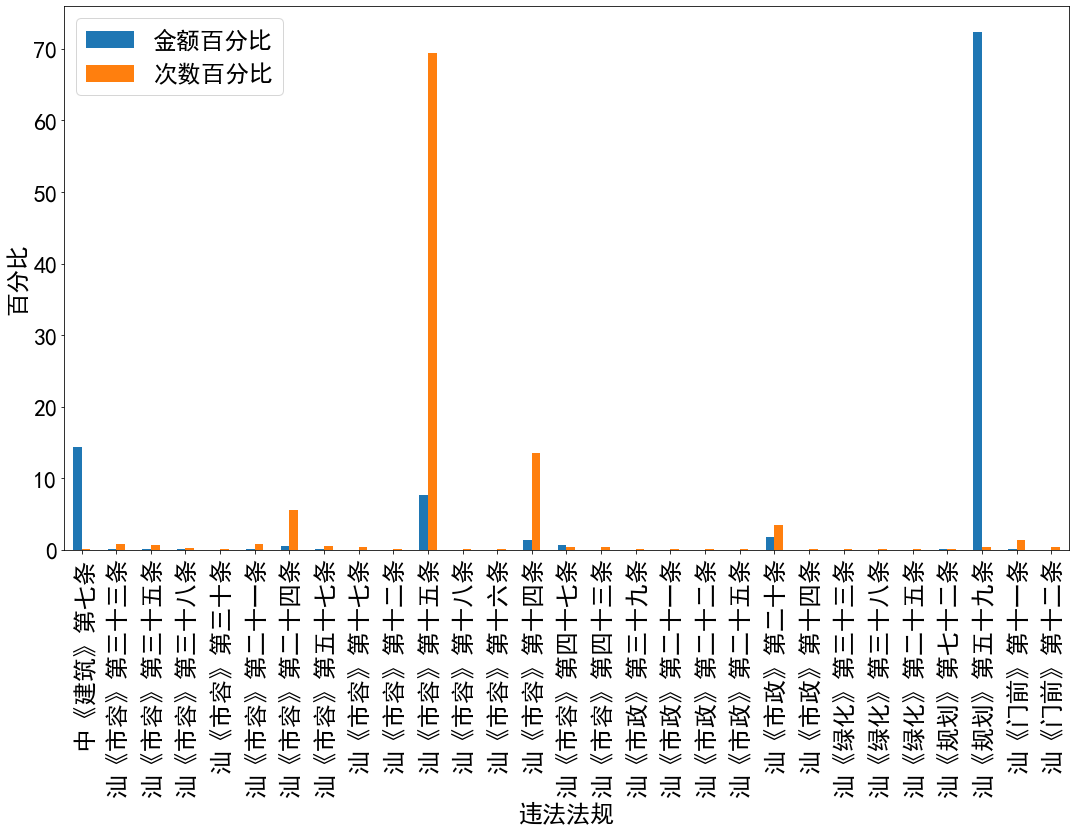

In [10]:
#设置图形大小
data_vs[['金额百分比','次数百分比']].plot(kind='bar',figsize=(18,10),xlabel='违法法规',ylabel='百分比')


* 可以看出:
    - 处罚金额占比最多的法规是《汕头经济特区城乡规划条例》第五十九条、《中华人民共和国建筑法》第七条,但处罚次数极少
    - 处罚次数占比最多的法规是《汕头市城市市容环境卫生管理条》第十五条、《汕头市城市市容环境卫生管理条》第十四条;
    - 绝大部分部分(95%)处罚金额在1000元以下;

### 处罚时间

In [11]:
# object转DatetimeIndex
data['punishDate'] = pd.to_datetime(data['punishDate'])
data.set_index('punishDate',inplace=True)

In [12]:
#重采样和频度转换,需先设置时间索引
data_tc = data['remark'].resample('M').count()
data_tc.describe(percentiles=[.25,.75,.9,.95,.99])

count    34.00
mean     42.29
std      45.14
min       0.00
25%       0.00
50%      33.00
75%      70.25
90%     101.20
95%     124.30
99%     152.35
max     154.00
Name: remark, dtype: float64

<AxesSubplot:xlabel='时间', ylabel='处罚次数(罚款)'>

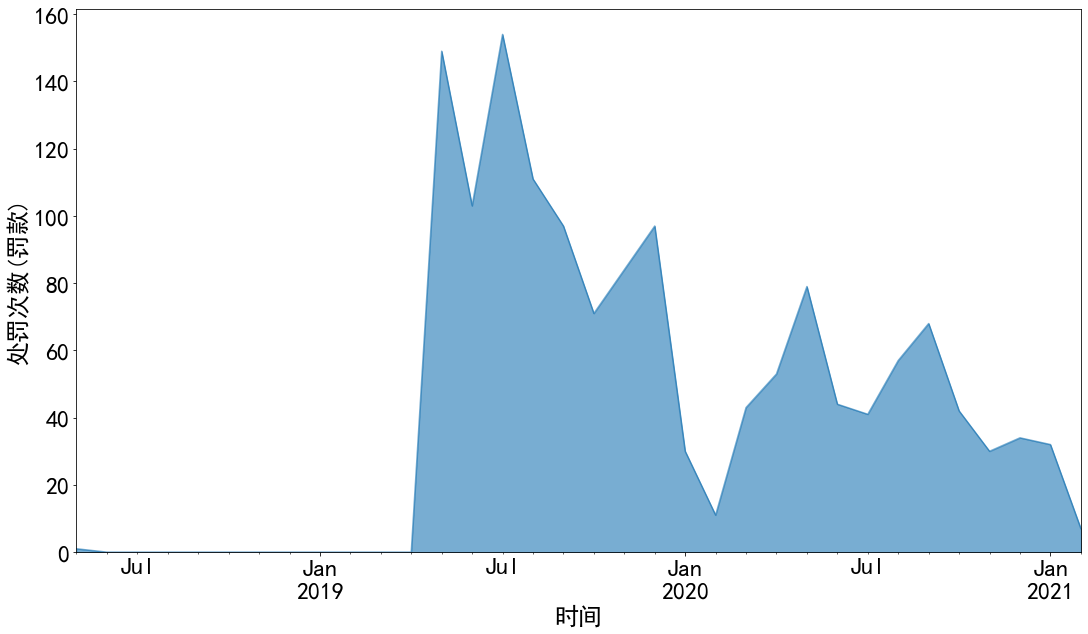

In [13]:
data_tc.plot(kind='area',alpha=0.6,figsize=(18,10),xlabel='时间',ylabel='处罚次数(罚款)')

* 可以看出:
    - 2019年6月,2019年8月处罚案件数最多,达149、154件
    - 月均处罚42.29件

### 行政相对人类型
* 按照违法法规、行政相对人类型对违法金额金额进行汇总，类似excel中的透视表操作，聚合函数为sum

<AxesSubplot:xlabel='illegalLaw'>

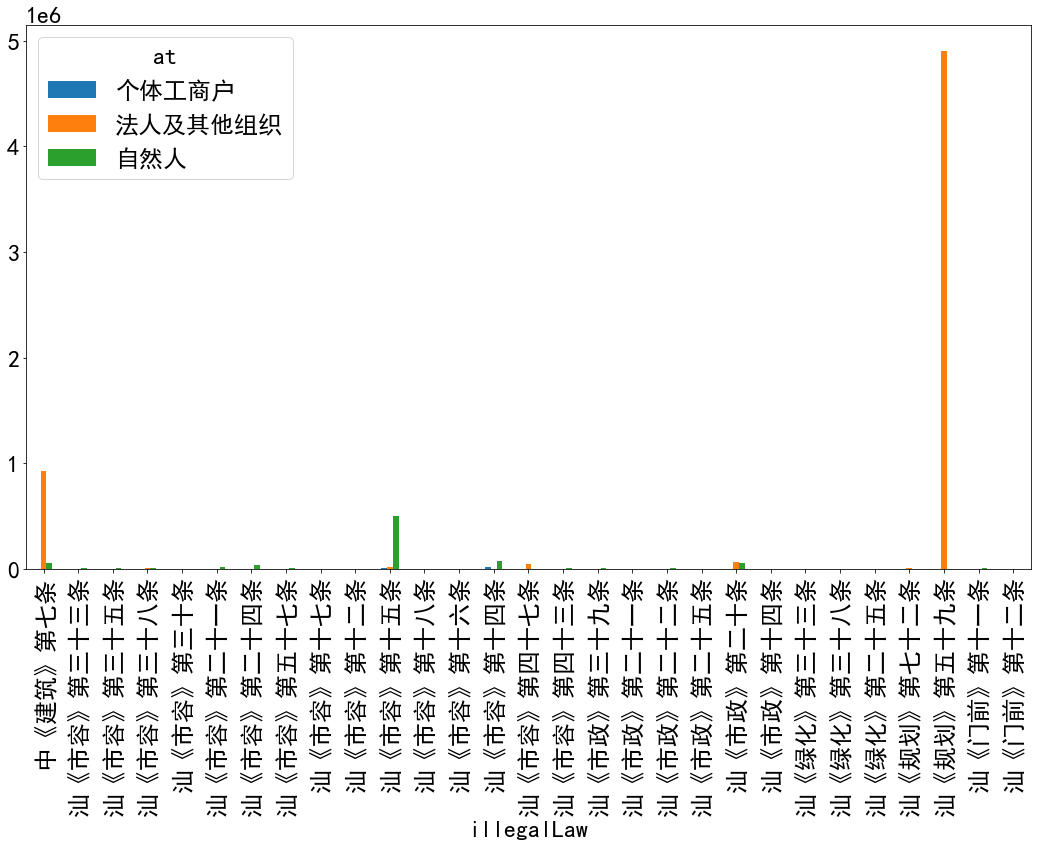

In [17]:

atMap = {
    1:"法人及其他组织",
    2:"自然人",
    3:"个体工商户"
}
k = lambda x: atMap.get(x, x)
data['at'] = data.admCounterCategory.map(k)

data.groupby('at')['punishAmount'].sum().sort_values(ascending=False)

# nan替换成0
by_occupation = data.pivot_table('punishAmount',index='illegalLaw',columns='at',aggfunc='sum').fillna(0)
#by_occupation.style.set_table_attributes('style="font-size:24px"')
by_occupation.plot(kind='bar',figsize=(18,10))



* 算出每种类型的行政相对人受到的罚款金额占比

<AxesSubplot:xlabel='违法法规', ylabel='占比'>

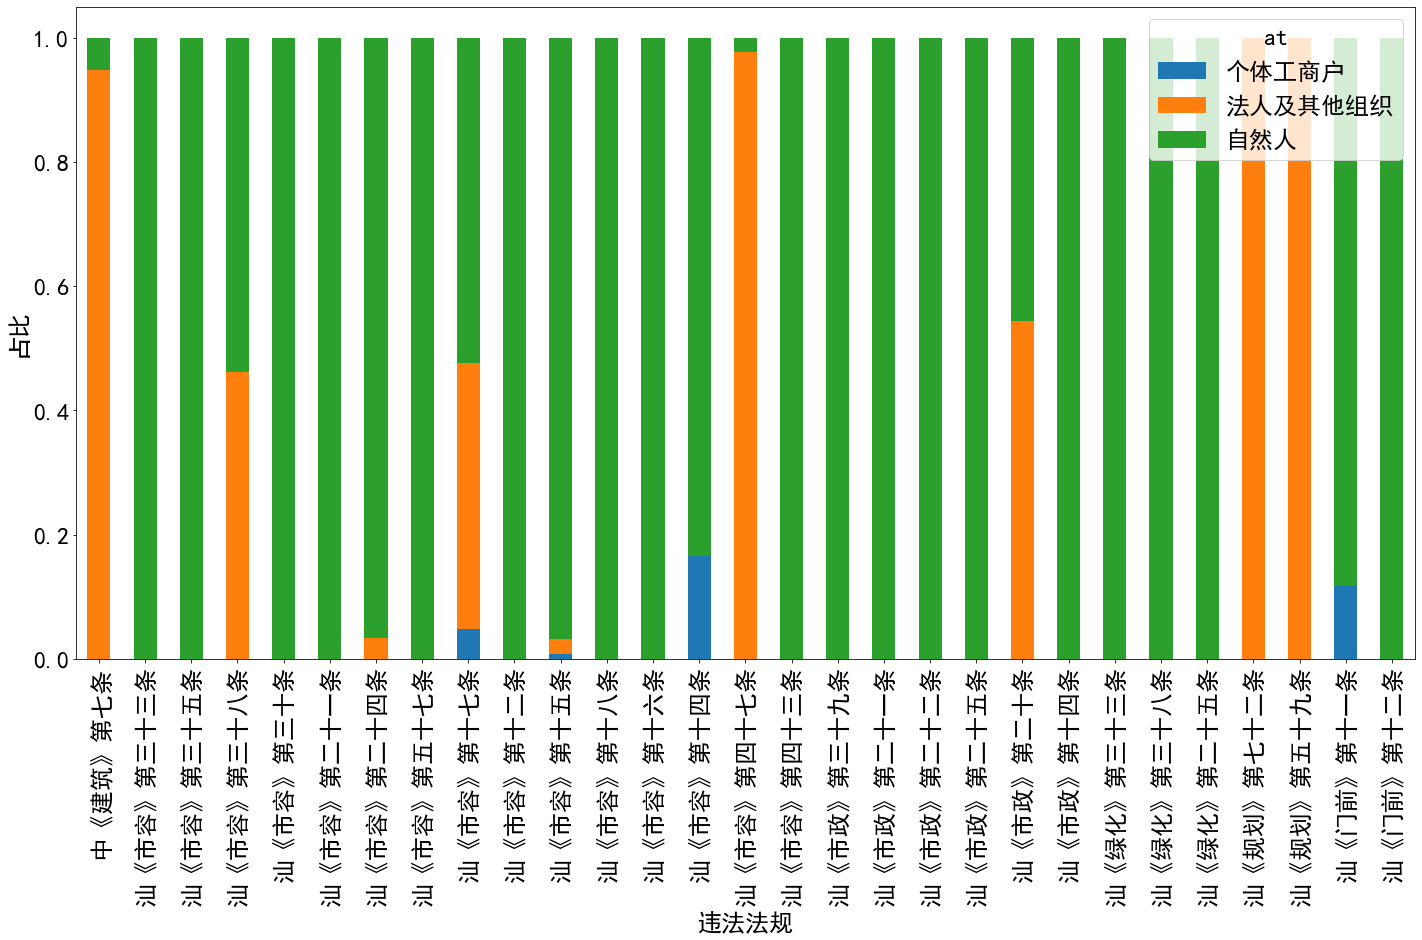

In [15]:
normed_sums = by_occupation.div(by_occupation.sum(axis=1),axis=0)
normed_sums.plot(kind='bar',stacked=True,figsize=(24,12),xlabel='违法法规',ylabel='占比')


* 可以看出:
    - 绝大部分处罚金额对应的行政相对人类型为法人及其他组织,且依据的法规集中为《汕头经济特区城乡规划条例》第五十九条、《中华人民共和国建筑法》第七条;
    - 《汕头经济特区城乡规划条例》第五十九条、《中华人民共和国建筑法》第七条、《汕头市城市市容环境卫生管理条例》第四十七条、《汕头经济特区城乡规划条例》第七十二条的处罚对象类型基本为法人及其他组织;

## 后续完善
* 分析数据的指标单一,搞数据分析需要统计学素养,这方面还需恶补;
* 执法数据中的违法事实(illegalFact)中基本包含地点信息,如‘2020年8月7日在汕头市金环南路与东方街交界西北侧步道擅自占用城市步道堆放“哈啰”共享单车、助力车，经责令整改无整改。’,下一步将尝试将其中的地点信息提取出来,根据处罚次数和处罚金额做热力图。
* 如果有现成的信息提取工具,麻烦大家推荐。
